In [1]:
from sklearn.model_selection import KFold
import pickle
import pandas as pd
import os.path
file_name = 'resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_folds,test_folds = pickle.load(handle)  

                                            

In [2]:
import torch
import torch.nn as nn
class Model(torch.nn.Module):
    def __init__(self,device, input_dim=64):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 512
        self.linear1 = torch.nn.Linear(input_dim, self.hidden_dim)
        self.linear2= torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear3= torch.nn.Linear(self.hidden_dim, 250)
        self.device = device
        self.to(device)
    def forward(self, x):
        y= self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))
        y = torch.sigmoid(y)
        return y


In [3]:
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
class CalculateMSE():
    def __init__(self, net,n_epochs,batch_size ):
        super().__init__()
        self.net = net
        #initialize some constants
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)   
    def weights_init(self,layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)
    def get_mse(self,train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data), 
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data), 
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) # weight_decay=0
        for epoch in range(0, self.n_epochs):
            epoch_train_loss=[]
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.net.device))
                loss = criterion(y_pred, label.to(self.net.device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.item())
            tloss.append(np.mean(epoch_train_loss))
            epoch_loss=[]
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs1, label1 = data
                    y_pred1 = self.net(inputs1.to(self.net.device))
                    loss1 = criterion(y_pred1, label1.to(self.net.device))
                    epoch_loss.append(loss1.item())
            vloss.append(np.mean(epoch_loss))
        return np.min(vloss), self.net


In [4]:
from pathlib import Path
n_epochs=3000
batch_size=32
PATH = 'saved_model/DNN_combined_poisson_15percent/'
Path(PATH).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl = Model(device=device, input_dim=64)
losses = []
from scipy.stats import poisson
def add_noise(inputs,inputs2, a = 0.02, std = 0.02, sequence_length=64, noise_seed=None):
    if noise_seed is not None:
        np.random.seed(noise_seed)
    noise = np.random.normal(0,std, size = (inputs.shape[0], sequence_length)).astype(np.float32)
    noise2 = np.random.normal(0,std, size = (inputs2.shape[0], sequence_length)).astype(np.float32)
    #noise = poisson.rvs(mu, size=(inputs.shape[0], sequence_length)).astype(np.float32)
    
    nsd = a*np.random.poisson(inputs/a).astype(np.float32)
    nsd2 = a*np.random.poisson(inputs2/a).astype(np.float32)
    
    # Calculate the absolute error between nsd and original inputs
    absolute_error = np.abs(nsd - inputs)
    absolute_error2 = np.abs(nsd2 - inputs2)
    # Sum up the absolute errors
    total_error = np.sum(absolute_error)
    total_error2 = np.sum(absolute_error2)
    # Sum of the original data
    total_original = np.sum(inputs)
    total_original2 = np.sum(inputs2)

    # Calculate the noise ratio
    noise_ratio = (total_error+total_error2) / (total_original+total_original2)
    
    return nsd, nsd2, noise_ratio
noise_ratios = []
for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    
    # Adding noise to the train and test data
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0145, std = 0.05, sequence_length=64, noise_seed=i)
    print(noise_ratio)
    noise_ratios.append(noise_ratio)
    mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    losses.append(loss)
    print(i,loss)
    torch.save(model.state_dict(), PATH+'model'+str(i))
print(np.mean(noise_ratios))

0.15039622228224697
0 0.009606156405061484
0.15074657530929558
1 0.011002792697399854
0.15002534833516407
2 0.01133514679968357
0.14982909550998555
3 0.010439838841557502
0.15032643298027912
4 0.008678525034338237
0.15019829508044108
5 0.012024581991136074
0.14926895161274054
6 0.00859653134830296
0.1504189650042778
7 0.008185929805040359
0.14983433085840742
8 0.008514294680207968
0.14946087188089238
9 0.006672405079007149
0.15005050888537302


In [5]:
print(np.mean(losses),np.std(losses))

0.009505620268173516 0.001583624938859845


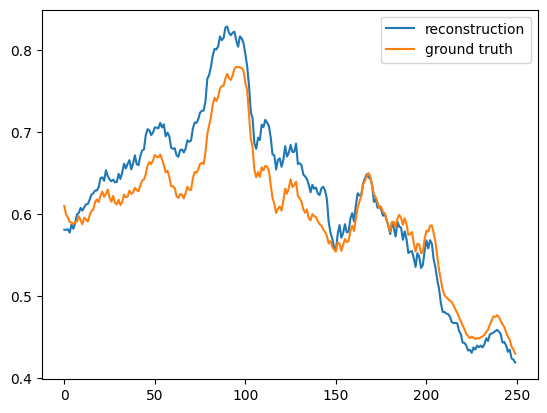

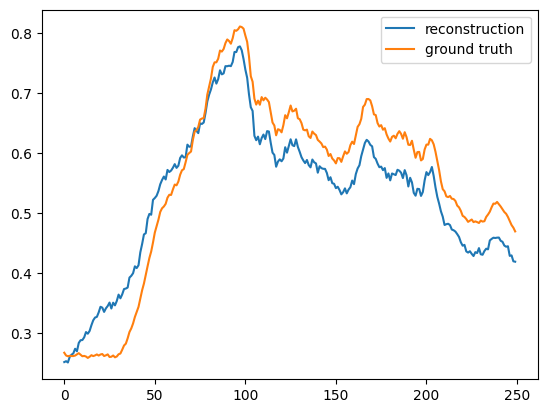

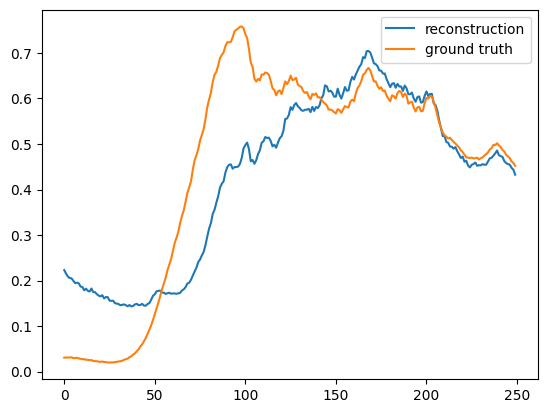

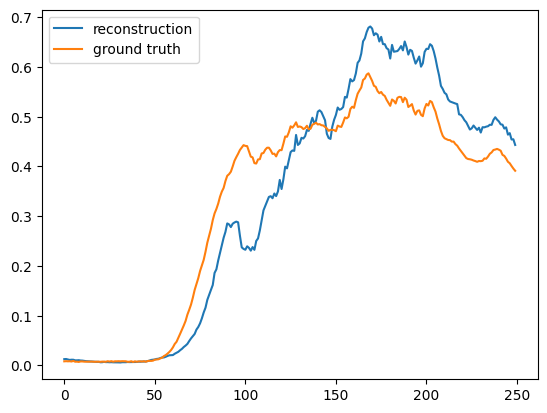

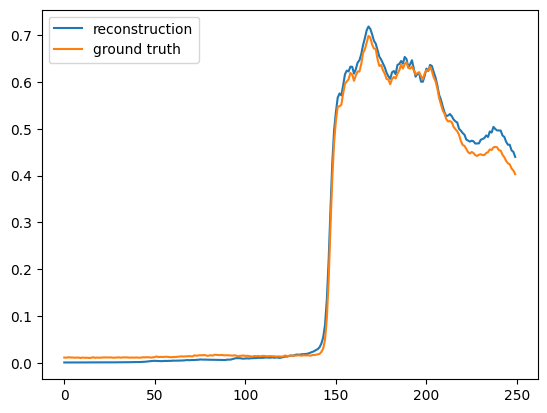

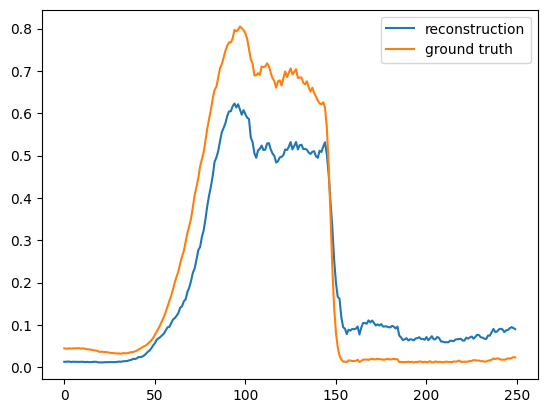

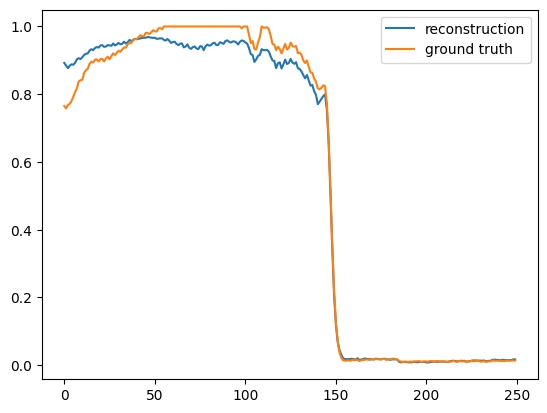

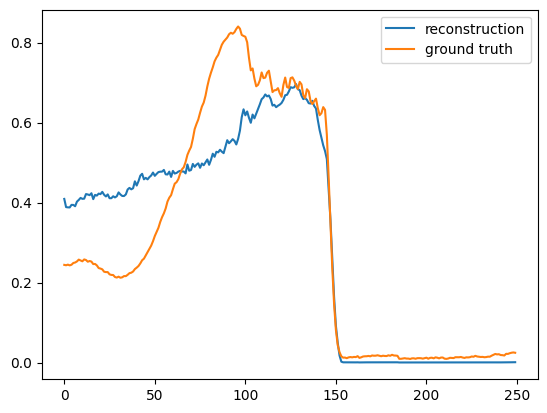

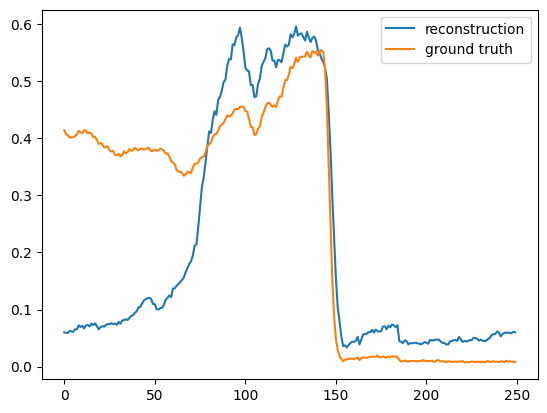

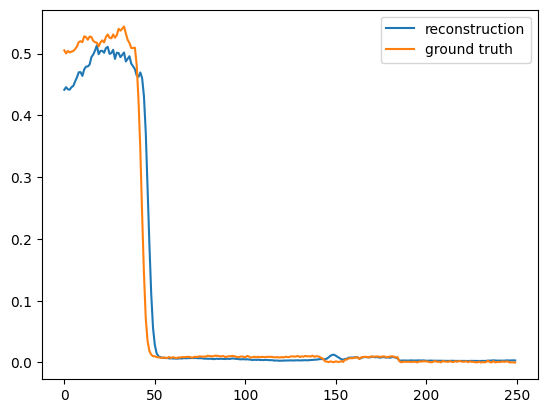

In [6]:
number_figures = 10
import matplotlib.pyplot as plt

indices = torch.randint(0,len(test_label),(number_figures,)).unique()
for i in indices:
    res = test_data[i]
    spec = test_label[i]
    plt.figure(i)

    plt.plot(model(torch.Tensor(res).to(model.device)).detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])


In [7]:
from pathlib import Path
PATH = 'saved_model/DNN_combined_poisson_15percent/'
device = torch.device("cuda")
mdl = Model(device=device, input_dim=64)

from scipy import stats,spatial
#pip install dtw-python
from dtw import *
import torch
import numpy as np
correlation_losses = []
import dcor
def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    construction = model(test_data_tensor).detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    
    # Distance Correlation
    distance_corr = []
    
    #DTW distance
    alignment = []
    
    #absolute_error
    abs_err = []
    
    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(dcor.distance_correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results

for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    print(i)
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0145, std = 0.05, sequence_length=64, noise_seed=i)
    
    mdl_name = PATH + 'model' + str(i)
    mdl.load_state_dict(torch.load(mdl_name))
    mdl.eval()
    
    correlation_loss = calculate_correlation(mdl, test_data, test_label)
    correlation_losses.append(correlation_loss)
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

0


/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


1
2
3
4
5
6
7
8
9
pearson
0.8541355165244756 0.29448727358573235
0.01084660625543359 0.08223526216161145
kendall
0.6192594321808307 0.23852035176628253
0.0077394543579385544 0.06850238919405349
spearman
0.7559473563933579 0.27586591182118564
0.009542319599654892 0.07365001928923381
DTW
11.348963135686077 14.898229330749501
Absolute Error
5
0.0015242317344131232
50
0.02533598567254436
90
0.18212646516695005
95
0.27653464645188175
99
0.5227935519329178
Distance Correlation
0.8958848933644147 0.17438708195612132
